# LUAD CPTAC analysis

In [1]:
import pandas as pd
import numpy as np
from msresist.pre_processing import preprocessing
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## 1 - Import and Preprocess Data

In [3]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [4]:
X

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,...,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsGGGVS,NP_002577.2,PBX2,S146-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.254230,-0.378522,0.987749,-0.189486
2,AAAAAsTQAQQ,NP_001035540.1,MINDY2,S575-p,0.012034,-0.630863,-1.159479,-0.740044,0.107228,-0.016971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42378,YYSTEsEPLTN,NP_055869.1,UHRF1BP1L,S777-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42379,YYTAGyNSPVK,NP_001313309.1,HEBP2,Y179-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.631923,-1.911083,0.620938,-0.654537,0.974769,-1.261869,0.726954,-1.583683
42380,YYTIPsMDDLA,NP_057404.2,NUP98,S746-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42381,YYTSAsGDEMV,NP_001017963.2,HSP90AA1,S470-p,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.719128,-0.937400,0.296906,-0.821107,0.837424,-0.427417,0.716933,-0.880607,0.606949,-0.533247


### Distribution of Missingness

In [5]:
p_nan_counts = []
for i in range(d.shape[1]):
    p_nan_counts.append(np.count_nonzero(np.isnan(d[i])))

distribution mean: 152.76464620248686


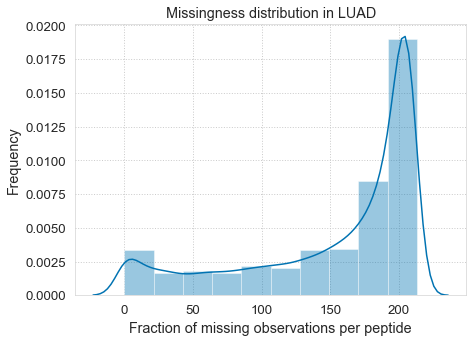

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = sns.distplot(p_nan_counts, 10)
ax.set_title("Missingness distribution in LUAD")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of missing observations per peptide")

print("distribution mean:", np.mean(p_nan_counts))

### Filter peptides based on a threshold of missingness

In [7]:
from msresist.pre_processing import filter_NaNpeptides

X_f = filter_NaNpeptides(X, cut=0.10)
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

## 2 - Run Model

Reduce data set:

In [8]:
# Reduce data set?
# npept = 7000
# d = d.iloc[:, :npept]
# i = i.iloc[:npept, :]

#Drop NaN?
# d = d.iloc[:8, :].dropna(axis=1)
# i = i.iloc[d.columns, :]

Run model:

In [ ]:
%%time
distance_method = "PAM250"
ncl = 25
SeqWeight = 10

MSC = MassSpecClustering(i_f, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d_f, "NA")

init
initialized
Compute all pairwise distances
pairwise distances matrix ready
start EM
__________________________________________
N_ITER: 0
25
Cluster sizes: [624, 624, 55, 23, 3239, 114, 485, 211, 61, 2680, 2780, 190, 43, 4580, 67, 217, 1495, 4685, 222, 69, 820, 295, 253, 180, 1254]
58.269032678091904
SeqWins: 45 DataWins: 24316 BothWin: 607 MixWin: 298
__________________________________________
N_ITER: 1
25
Cluster sizes: [616, 633, 55, 36, 3207, 116, 517, 211, 59, 2630, 2775, 184, 54, 4602, 66, 218, 1498, 4690, 231, 67, 803, 305, 252, 200, 1241]
65.35787074235701
SeqWins: 61 DataWins: 24427 BothWin: 590 MixWin: 188
__________________________________________
N_ITER: 2
25
Cluster sizes: [865, 500, 62, 66, 3618, 109, 554, 164, 65, 3339, 3242, 187, 66, 3735, 76, 343, 1426, 3497, 311, 87, 727, 413, 419, 271, 1124]
67.84163990006427
SeqWins: 79 DataWins: 24178 BothWin: 824 MixWin: 185
__________________________________________
N_ITER: 3
25
Cluster sizes: [968, 439, 70, 94, 3769, 96, 603

In [10]:
centers = MSC.transform(d_f)

NameError: name 'MSC' is not defined

In [ ]:
raise SystemExit

In [ ]:
from msresist.figures.figure1 import plotClustergram
import seaborn as sns
plotClustergram(centers.T, "", lim=max(np.max(np.abs(centers.T)) * 0.2), figsize=(20, 20))
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p1 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p1, d, y_, 1, 10)

In [ ]:
cf = pd.read_csv("Y_CPTAC.csv")
cf_ = cf.replace("Living", 0)
cf_ = cf_.replace("Deceased", 1)
cf_ = cf_.replace("No", 0)
cf_ = cf_.replace("Yes", 1)

In [ ]:
IDict = pd.read_csv("IDs.csv", header=0)
IDict_ = dict(zip(IDict.iloc[:, 0], IDict.iloc[:, 1]))

In [ ]:
ids = []
for i in range(cf.shape[0]):
    ids.append(IDict_[cf_.iloc[i, 0]])
cf_["Patient_ID"] = ids

In [ ]:
for i in range(cf_.shape[0]):
    id_ = cf_.iloc[i, 0].split(".N")[0]
    cf_.loc[-1] = [id_, cf_.iloc[i, 1], cf_.iloc[i, 2]]
    cf_.index = cf_.index + 1
cf_.loc[-1] = ["C3N.02379.1", 0, 0]
cf_.index = cf_.index + 1
cf_ = cf_.sort_index()

In [ ]:
for col in centers.columns:
    if col not in list(cf_["Patient_ID"]):
        print(col)

In [ ]:
centers = centers.drop(["C3N.02587", "C3N.02587.N"], axis=1)

In [ ]:
y = pd.read_csv("y.csv").set_index("Patient_ID")

In [ ]:
centers = centers.reset_index().drop("Clusters", axis=1).T.reset_index().sort_values(by="index")
y = y.reset_index().sort_values(by="Patient_ID")

In [ ]:
centers = centers.set_index("index")
y = y.set_index("Patient_ID")

In [ ]:
from msresist.figures.figure3 import plotR2YQ2Y
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p1, centers, y, 1, 10)

In [ ]:
centers.head()

In [ ]:
list(range(20))

In [ ]:
centers = centers.drop("C3N.00738.N")

In [ ]:
centers = centers.reset_index()

In [ ]:
from sklearn.decomposition import PCA
from msresist.figures.figure1 import pca_dfs

c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(centers.iloc[:, 1:])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, centers, c, ["index"], "Cluster")

In [ ]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [ ]:
tumortype = []
for i in range(dScor_.shape[0]):
    if ".N" in dScor_["Patient_ID"][i]:
        tumortype.append("Normal")
    else:
        tumortype.append("Tumor")

In [ ]:
dScor_["Type"] = tumortype

In [ ]:
varExp = np.round(pp.explained_variance_ratio_, 2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Type", style="Type", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.02, dLoad_.iloc[line, 1]+0.02, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)